# Exploratory data analysis

In [2]:
from datetime import datetime as dt
import sys
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sys.path.append('../..')  # Allow import of project packages
from utils.text import (
    trim_motion_text_by_subtitle,
    trim_leadning_motivation,
    trim_linebreaks,
    trim_motion_text_by_proposed_decision,
    trim_motion_text_by_leading_title,
    trim_whitespace,
    set_empty_when_leading_date,
    delete_footer
)

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 500)

RANDOM_STATE = 1
DATA_PATH = "../../data/downloaded/raw_swe_parl_mot.pkl"

### Load Data

In [3]:
raw = pd.DataFrame(pd.read_pickle(DATA_PATH))
display(raw.info())

df = raw.copy()
df['date'] = pd.to_datetime(df['date'])
df['file_date'] = pd.to_datetime(df['file_date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167782 entries, 0 to 167781
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            167782 non-null  object
 1   date          167782 non-null  object
 2   file_date     167782 non-null  object
 3   title         167782 non-null  object
 4   subtitle      167256 non-null  object
 5   text          167782 non-null  object
 6   main_author   167781 non-null  object
 7   author_party  167689 non-null  object
dtypes: object(8)
memory usage: 10.2+ MB


None

### Describe data

In [4]:
# Show sample rows
display(df.sample(1, random_state=RANDOM_STATE))

,id,date,file_date,title,subtitle,text,main_author,author_party
9083,H4023374,2016-10-05,2018-06-12 15:57:11,Kommunikationer,av Nina Lundström (L),Motion till riksdagen 2016/17:3374 av Nina Lundström (L) Kommunikationer Förslag till riksdagsbeslut Riksdagen ställer sig bakom det som anförs i motionen om satsningar på cykling och tillkännager detta för regeringen. Riksdagen ställer sig bakom det som anförs i motionen om vägar och tillkännager detta för regeringen. Riksdagen ställer sig bakom det som anförs i motionen om införande av avgift för dubbdäck och tillkännager detta för regeringen. Riksdagen ställer sig bakom det som anförs i m...,Nina Lundström,L


About 167k samples. Let's just go ahead and drop any row with a missing value, for simplicity.

In [5]:
df = df.dropna()
display(df.describe())

,id,date,file_date,title,subtitle,text,main_author,author_party
count,167164,167164,167164,167164,167164,167164,167164,167164
unique,167164,4441,130291,109984,30344,167038,4413,50
top,H2021,1991-01-25 00:00:00,2007-02-28 10:52:33,med anledning av prop. 1989/90:90 om forskning,av Sten Bergheden (M),Dokument saknas,LARS WERNER,M
freq,1,3719,1963,200,785,120,1889,24669
first,NaN,1970-01-12 00:00:00,1999-09-16 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-06-17 00:00:00,2022-07-08 16:15:57,NaN,NaN,NaN,NaN,NaN


There's a few things to note here.
* The ID's are unique. 
* On the top date 25th Jan 1991 there were 3 719 motions filed. That warrants a closer look.  
* The titles are not unique. In fact 200 motions share the same title "med anledning av prop. 1989/90:90 om forskning"  
* There's som cleaning up left to do based on the text-column. Now 125 only has 'dokument sakans' (document missing) as string.  We'll want to drop those from the data later.

#### Over 3k motions on 1991-01-25

Let's first see how may motions are usually filed on any particular date

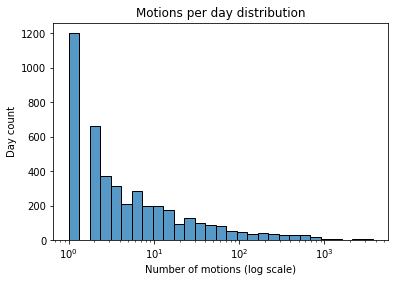

In [6]:
sns.histplot(df.groupby('date').size(), kde=False, log_scale=True)
plt.title('Motions per day distribution')
plt.xlabel('Number of motions (log scale)')
plt.ylabel('Day count')
plt.show()

While 3k+ on a day is certainly an outlier, it's not the only date that has a large number of motions associated with it. Below is the top ten most common titles for motions on 25th Jan 1991.

In [7]:
# Show top ten titles on 1991-01-25
display(df[df['date'].dt.date == dt(1991, 1, 25).date()].title.value_counts().head(10))

med anledning av prop. 1990/91:69 Arbetslivsforskningens organisation m.m.    8
Rattfylleri                                                                   8
Riksteatern                                                                   7
Avskaffande av skogsvårdsavgiften                                             7
Det allmännas skadeståndsansvar                                               6
med anledning av prop. 1990/91:71 Lag om vissa dryckesförpackningar           5
Mänskliga rättigheter                                                         5
Den ekonomiska politiken                                                      5
Registrerat partnerskap för homosexuella                                      5
Transportstödet                                                               5
Name: title, dtype: int64

There's not a high number of motions on any one title. I'm going to assume that these motions are valid data (maybe just filed on the wrong date).

#### The many documents with title 'med anledning av prop. 1989/90:90 om forskning'

In [8]:
df.loc[df['title'] == 'med anledning av prop. 1989/90:90 om forskning'].head(10)

,id,date,file_date,title,subtitle,text,main_author,author_party
88724,GD02A24,1990-03-19,2014-11-04 14:56:15,med anledning av prop. 1989/90:90 om forskning,av Anders Högmark m.fl. (m),Observera att dokumentet är inskannat och fel kan förekomma. Motion till riksdagen 1989/90:A24 av Anders Högmark m.fl. (m) med anledning av prop. 1989/90:90 om forskning 1. Inledning Inom arbetsmarknadsdepartementets ansvarsområde ligger bl.a. arbetsmiljöforskning och forskning kring s.k. arbetslivsfrågor. Inom dessa områden finns det omfattande forskningsmöjligheter. Villkoren och förutsättningarna för forskning inom dessa områden är dock speciella. En mycket stor del av forskningsanslagen ...,av Anders Högmark m.fl.,m
88735,GD02A25,1990-03-20,2014-11-04 14:56:16,med anledning av prop. 1989/90:90 om forskning,av Sven-Åke Nygårds m.fl. (s),Observera att dokumentet är inskannat och fel kan förekomma. Motion till riksdagen 1989/90:A25 av Sven-Åke Nygårds m.fl. (s) med anledning av prop. 1989/90:90 om forskning Förhållandena inom arbetsmiljöområdet har rönt en stegrande uppmärksamhet under senare år. Detta visas av att en arbetsmiljökommission har tillsatts. Inrättandet av en arbetslivsfond talar samma språk. I den forskningspolitiska propositionen 1989/90:90 har inte detta slagit igenom på samma sätt. För oss är det uppenbart at...,av Sven-Åke Nygårds m.fl.,s
88746,GD02A26,1990-03-20,2014-11-04 14:56:16,med anledning av prop. 1989/90:90 om forskning,av Jan Hyttring och Kjell Ericsson (båda c),Observera att dokumentet är inskannat och fel kan förekomma. Motion till riksdagen 1989/90:A26 av Jan Hyttring och Kjell Ericsson (båda c) med anledning av prop. 1989/90:90 om forskning Hemställan Med hänvisning till vad som anförts i motion 1989/90:Ubl45 hemställs att riksdagen beslutar att som sin mening ge regeringen till känna vad i motionen föreslås för arbetslivsforskning vid högskolan i Karlstad. Stockholm den 20 mars 1990 Jan Hyttring (c) Kjell Ericsson (c),Jan Hyttring,c
88757,GD02A27,1990-03-20,2014-11-04 14:56:17,med anledning av prop. 1989/90:90 om forskning,av Krister Skånberg (mp),Observera att dokumentet är inskannat och fel kan förekomma. Motion till riksdagen 1989/90:A27 av Krister Skånberg (mp) med anledning av prop. 1989/90:90 om forskning I denna motion anger jag en rad behov av lokal och regional utveckling och forskning och begär regeringsförslag om och resurser för sådan forskning. 1. Det behövs forskning om ev förändrade förutsättningar för en aktiv regionalpolitik i samband med den europeiska integrationen. Vilka spelregler kan och får vi använda i Sverige ...,av Krister Skånberg,mp
88768,GD02A28,1990-03-20,2014-11-04 14:56:17,med anledning av prop. 1989/90:90 om forskning,av Carl Bildt m.fl. (m),Observera att dokumentet är inskannat och fel kan förekomma. Motion till riksdagen 1989/90:A28 av Carl Bildt m.fl. (m) med anledning av prop. 1989/90:90 om forskning Hemställan Med hänvisning till vad som anförts i motion 1989/90:Ubl25 hemställs att riksdagen som sin mening ger regeringen till känna vad i motionen anförts om en avveckling av verksamheten i dess nuvarande form vid arbetslivscentrum och arbetsmiljöinstitutet. Stockholm den 20 mars 1990 Carl Bildt (m) Lars Tobisson (m) Anders B...,av Carl Bildt m.fl.,m
88779,GD02A29,1990-03-20,2014-11-04 14:56:18,med anledning av prop. 1989/90:90 om forskning,av Lars Werner m.fl. (vpk),"Observera att dokumentet är inskannat och fel kan förekomma. Motion till riksdagen 1989/90:A29 av Lars Werner m.fl. (vpk) med anledning av prop. 1989/90:90 om forskning Hemställan Med hänvisning till vad som anförts i motion 1989/90:Ubl39 hemställs att riksdagen till Arbetsmiljöinstitutet anslår 1 000000 kr. utöver regeringens förslag, för informationsverksamhet i enlighet med vad som anförts i motionen. Stockholm den 20 mars 1990 Lars Werner (vpk) Bertil Måbrink (vpk) Bo Hammar (vpk) Lars-O...",av Lars Werner m.fl.,vpk
88789,GD02A30,1990-03-20,2014-11-04 14:56:19,med anledning av prop. 1989/90:90 om forskning,Bör

At least after eye-balling just a few of these motions they seem fine. They're different documents, just on the same topic. But since we cant look at them all, let's drop any rows with identical combination of title and text.

In [9]:
df = df.drop_duplicates(subset=['text', 'title'])

### Preprocess text  

Many motions' raw structure are 
```
Observera att dokumentet är inskannat och fel kan förekomma. Motion till riksdagen <motion_serial> <motion_subtitle> <motion_title> <parliament_decision_proposal>. Motivering <motion_text> <motion_footer>
```
We'll leave the footer for now. The intention here is to delete the leading blocks so that `df['text']` starts with the actual motion text. Let's use the first motion as an example. We'd like this one to start with `"I den snabba ..."` when we're done.

In [10]:
first_motion = df['text'][0][:500]
print(first_motion)

Motion till riksdagen 2014/15:1 av Anders Ahlgren och Anders Åkesson (C) Utveckla en nationell strategi för tillväxt och grundläggande service i hela landet Förslag till riksdagsbeslut Riksdagen tillkännager för regeringen som sin mening vad som anförs i motionen om att utveckla en nationell strategi för tillväxt och grundläggande service i hela landet. Motivering I den snabba urbaniseringen som sker klyvs Sverige. Människor känner oro för sina jobb, för sitt företag, för sina barns uppväxtmiljö


In [11]:
# Initial cleaning
df["title"] = trim_whitespace(df["title"])
df["text"] = trim_linebreaks(df["text"])
df["text"] = trim_whitespace(df["text"])
df["text"] = df.apply(trim_motion_text_by_subtitle, axis=1)

first_motion = df['text'][0][:500]
print(first_motion)

Utveckla en nationell strategi för tillväxt och grundläggande service i hela landet Förslag till riksdagsbeslut Riksdagen tillkännager för regeringen som sin mening vad som anförs i motionen om att utveckla en nationell strategi för tillväxt och grundläggande service i hela landet. Motivering I den snabba urbaniseringen som sker klyvs Sverige. Människor känner oro för sina jobb, för sitt företag, för sina barns uppväxtmiljö och för tryggheten på ålderns höst. Detta blir tydligt när vi drar sluts


In [12]:
df["text"] = df.apply(trim_motion_text_by_leading_title, axis=1)

first_motion = df['text'][0][:500]
print(first_motion)

Förslag till riksdagsbeslut Riksdagen tillkännager för regeringen som sin mening vad som anförs i motionen om att utveckla en nationell strategi för tillväxt och grundläggande service i hela landet. Motivering I den snabba urbaniseringen som sker klyvs Sverige. Människor känner oro för sina jobb, för sitt företag, för sina barns uppväxtmiljö och för tryggheten på ålderns höst. Detta blir tydligt när vi drar slutsatser ifrån 2014 års val. Ska det vara möjligt att bo, arbeta och leva i hela landet


In [13]:
df["text"] = df.apply(trim_motion_text_by_proposed_decision, axis=1)

first_motion = df['text'][0][:500]
print(first_motion)

Motivering I den snabba urbaniseringen som sker klyvs Sverige. Människor känner oro för sina jobb, för sitt företag, för sina barns uppväxtmiljö och för tryggheten på ålderns höst. Detta blir tydligt när vi drar slutsatser ifrån 2014 års val. Ska det vara möjligt att bo, arbeta och leva i hela landet? Är det viktigt att även boende på landsbygden har tillgång till bredband, bensinstationer, livsmedelsbutik, kollektivtrafik, skola och vårdcentral? Tycker du att beslut ska fattas så nära människor


In [14]:
df["text"] = df.apply(trim_leadning_motivation, axis=1)
df["text"] = df.apply(set_empty_when_leading_date, axis=1)
df["text"] = df.apply(delete_footer, axis=1)

first_motion = df['text'][0][:500]
print(first_motion)

I den snabba urbaniseringen som sker klyvs Sverige. Människor känner oro för sina jobb, för sitt företag, för sina barns uppväxtmiljö och för tryggheten på ålderns höst. Detta blir tydligt när vi drar slutsatser ifrån 2014 års val. Ska det vara möjligt att bo, arbeta och leva i hela landet? Är det viktigt att även boende på landsbygden har tillgång till bredband, bensinstationer, livsmedelsbutik, kollektivtrafik, skola och vårdcentral? Tycker du att beslut ska fattas så nära människor som möjlig


That's it. Now let's take another look at the text column as a whole. There's a lot of junk in the texts that are very short after the preprocessing. For now we'll just drop all rows with a text that's shorter than 150 charachters.

In [37]:
# Show some eamples of short texts before dropping them
display(df[df['text'].str.len() < 150])
df = df.loc[df['text'].str.len() >= 150]

,id,date,file_date,title,subtitle,text,main_author,author_party
124,H202111,2014-10-29,2016-07-08 10:31:51,Värna om Sveriges framtida energiförsörjning,av Jenny Petersson m.fl. (M),Jenny Petersson (M) Jörgen Warborn (M) Michael Svensson (M),Jenny Petersson,M
528,H2021474,2014-11-07,2016-04-27 13:43:05,Principerna för beskattning,av Sofia Arkelsten (M),Sofia Arkelsten (M),Sofia Arkelsten,M
1523,H202237,2014-11-04,2016-04-26 15:57:52,Översyn av kommunens ansvar och föräldrabalken,av Maria Stockhaus (M),Maria Stockhaus (M),Maria Stockhaus,M
3289,H3021225,2015-10-05,2016-05-23 14:51:47,Sveriges framtida energiförsörjning,av Jenny Petersson m.fl. (M),Jenny Petersson (M) Jörgen Warborn (M) Michael Svensson (M),Jenny Petersson,M
3547,H3021458,2015-10-05,2016-12-13 17:12:39,Riksväg 55,av Erik Bengtzboe (M),Erik Bengtzboe (M),Erik Bengtzboe,M
...,...,...,...,...,...,...,...,...
161496,GJ02U21,1996-01-26,2005-11-02 21:56:59,med anledning av skr. 1995/96:30 EU:s regeringskonferens 1996,av Alf Svensson m.fl. (kds),Dokument saknas,Alf Svensson,kds
161516,GJ02U4,1995-11-14,2005-11-02 21:50:50,med anledning av skr. 1995/96:40 FN inför framtiden,av Bodil Francke Ohlsson och Marianne Samuelsson (mp),Dokument saknas,Bodil Francke Ohlsson,mp
161519,GJ02U42,1996-03-28,2005-11-02 22:03:19,med anledning av redog. 1995/96:NR1 Nordiska rådets svenska delegations berättelse angående verksamheten efter rådets 44:e session t.o.m. den 47:e sessionen,av Elver Jonsson och Anne Wibble (fp),Dokument saknas,Elver Jonsson,fp
161532,GJ02Ub12,1996-03-19,2005-11-02 21:53:39,med anledning av redog. 1995/96:RJ1 Styrelsen för Stiftelsen Riksbankens Jubileumsfonds berättelse över fondens verksamhet och förvaltning under år 1995,av Britt-Marie Danestig-Olofsson och Johan Lönnroth (v),Dokument saknas,Britt-Marie Danestig-Olofsson,v


### Title lengths

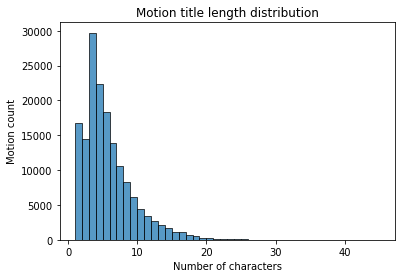

In [39]:
# Plot distribution of title lengths
num_words = list(len(x) for x in df['title'].str.split())
sns.histplot(num_words, binwidth=1)
plt.title('Motion title length distribution')
plt.xlabel('Number of characters')
plt.ylabel('Motion count')
plt.show()

The distribution as a whole looks reasonable. We've seen that certain titles are the same for multiple documents which may explain the slightly ragged shape.

### Motion text length

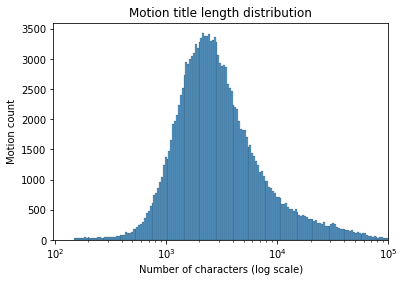

In [40]:
# Plot distribution of text lengths
sns.histplot(df['text'].str.len(), log_scale=True)
plt.title('Motion title length distribution')
plt.xlabel('Number of characters (log scale)')
plt.ylabel('Motion count')
plt.xlim(0, 100_000)
plt.show()

The median lengths is 2 700 and the mean is 5 500. It's quite common for a motion to be 10k characters or longer.